<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="4"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>Entity Resolution in Dissimilarity Spaces  <br></b> 
    </font>
     <br>
     <font size="3">
        Implementation notebook     
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos, BS Student</b>
     </font>
</div>
<br>
<div align="center"> 
    <font size="4">
     <b> Dr. Alex Delis</b>,  Professor NKUA <br> 
     <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Implementation__

## __Install components__

In [ ]:
!pip install editdistance
!pip install pandas_read_xml
!pip install requests
!pip install python-igraph

## __Import libraries__

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

import itertools 
import sklearn

plt.style.use('seaborn-white') # plot style

In [2]:
%load_ext autoreload
%autoreload 2

## __Model__

In [33]:
from model import RankedWTAHash, evaluate, customClassificationReport, report


# __Evaluation__

## Load data from Drive in Colab

In [4]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [5]:
CORA_groundTruth = os.path.abspath("../data/coraIdDuplicates.csv")
CORA = os.path.abspath("../data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth,sep='|',header=None,names=['id1','id2'])
CORA_groundTruth=CORA_groundTruth.sort_values(by=['id1','id2'],ignore_index=True)
CORA = pd.read_csv(CORA,sep='|')
CORA

,Entity Id,address,author,editor,institution,month,note,pages,publisher,title,venue,volume,year,Unnamed: 13
0,0,"los alamitos, ca:","p. auer, n. cesa-bianchi, y. freund, and r. e....",NaN,NaN,NaN,NaN,pp. 322-331.,"ieee computer society press,",'gambling in a rigged casino: the adversarial ...,in proc. 36th annual symposium on foundations ...,NaN,"1995,",NaN
1,1,NaN,"a. blum, m. furst, m. j. kearns, and richard j...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
2,2,NaN,"avrim blum, merrick furst, michael kearns, and...",NaN,NaN,NaN,NaN,"pages 24.1-24.10,",NaN,cryptographic primitives based on hard learnin...,"in pre-proceedings of crypto '93,",NaN,1993.,NaN
3,3,NaN,"avrim blum, merrick furst, michael kearns, and...","in douglas r. stinson, editor,",NaN,NaN,lecture notes in computer science no. 773.,pages 278-291.,"springer,",cryptographic primitives based on hard learnin...,"proc. crypto 93,",NaN,1994.,NaN
4,4,NaN,"a. blum, m. furst, m. kearns, r. lipton.",NaN,NaN,NaN,NaN,NaN,NaN,cryptographic primitives based on hard learnin...,"crypto,",NaN,1993.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,1290,NaN,robert e. schapire and yoram singer.,NaN,NaN,NaN,NaN,NaN,NaN,improved boosting algorithms using confidence-...,in proceedings of the eleventh annual conferen...,NaN,1998.,NaN
1291,1291,NaN,"schapire, r. e., freund, y., bartlett, p., & l...",NaN,NaN,NaN,annals of statistics (to appear).,NaN,NaN,boosting the margin: a new explanation for the...,NaN,NaN,(1998).,NaN
1292,1292,NaN,robert e. schapire and yoram singer. boostexter:,NaN,NaN,NaN,NaN,NaN,NaN,a system for multiclass multi-label text categ...,"unpublished manuscript,",NaN,1998.,NaN
1293,1293,NaN,robert e. schapire yoram singer.,NaN,NaN,NaN,submitted for publication. 17,NaN,NaN,improved boosting algorithms using confidence-...,NaN,NaN,NaN,NaN


In [6]:
CORA_groundTruth.head(10)

,id1,id2
0,1,2
1,1,3
2,1,4
3,2,3
4,2,4
5,3,4
6,5,6
7,5,7
8,5,8
9,5,9


#### CENSUS

In [7]:
CENSUS_groundTruth = os.path.abspath("../data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("../data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
CENSUS

,Entity Id,attr1,attr2,attr3,attr4,attr5,Unnamed: 6
0,0,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
1,1,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
2,2,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
3,3,ANDERSON,NaN,NaN,4848,BASSWOOD,NaN
4,4,AQUENDO,CLARA,J,666,STARKEY,NaN
...,...,...,...,...,...,...,...
836,836,WILLIAM,SHERRY,V,510,WOODHAVEN,NaN
837,837,WRIGHT,BRYAN,NaN,307,WOODHAVEN,NaN
838,838,WRIGHT,MAXINE,H,307,WOODHAVEN,NaN
839,839,YATES,CHANSE,E,403,WOODHAVEN,NaN


In [8]:
CENSUS_groundTruth

,id1,id2
0,85,530
1,427,816
2,360,748
3,18,462
4,299,692
...,...,...
339,433,827
340,366,755
341,651,652
342,226,602


#### CDDB

In [9]:
CDDB_groundTruth = os.path.abspath("../data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("../data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
CDDB

,Entity Id|artist,category,cdextra,genre,title,track01,track02,track03,track04,track05,...,track92,track93,track94,track95,track96,track97,track98,track99,year,Unnamed: 105
0,pink floyd,data,ID3G: 254,Data,the wall disc 1,in the flesh,the thin ice,another brick in the wall part 1,the happiest days of our lives,another brick in the wall part 2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Carlos Santana,data,NaN,NaN,Carlos,(Da Le) Yaleo,Love Of My Life,Put You Love Lights On,Smooth,Do You Like The Way?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Frans Bauer,data,NaN,Other,'n ons geluk,'n ONS geluk,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,NaN
3,2Pac,data,YEAR: 1998 ID3G: 15,Rap,Greatest Hits (CD1),Keep Ya Head Up,2 Of Amerikaz Most Wanted (Ft. Snoop Dogg),Temptations,God Bless The Dead,Hail Mary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998,NaN
4,Ì¤ï¿½ï¿½,data,NaN,NaN,Ì¤ï¿½ï¿½,ï¿½È¥ï¿½Ã¥ï¿½ 1,ï¿½È¥ï¿½Ã¥ï¿½ 2,ï¿½È¥ï¿½Ã¥ï¿½ 3,ï¿½È¥ï¿½Ã¥ï¿½ 4,ï¿½È¥ï¿½Ã¥ï¿½ 5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,Various,soundtrack,NaN,NaN,Warriors of Virtue,You Can Fly,A Beautiful Morning,Forces of Nature,Inside of You,Tennessee Plates,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9759,James Patterson,soundtrack,NaN,Soundtrack,Pop Goes the Weasel - CD 4,4.01,4.02,4.03,4.04,4.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
9760,Colin Baker & Nicholas Courtney,soundtrack,Published by Big Finish Productions.\nhttp://w...,Soundtrack,The Spectre of Lanyon Moor,Episode 0,Episode 1 Part 1,Episode 1 Part 2,Episode 1 Part 3,Episode 1 Part 4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,NaN
9761,Studio Cutz,soundtrack,ID3G: 24,Soundtrack,Volume 25,All Access 3:12,All Access 3:12 alt,All Access :60,All Access :30,All Access :11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
CDDB_groundTruth

,id1,id2
0,315,384
1,456,457
2,11,18
3,133,134
4,65,148
...,...,...
294,206,207
295,345,446
296,407,425
297,229,350


#### DBLP - ACM

In [11]:
ACM = os.path.abspath("../data/ACM.csv")
DBLP = os.path.abspath("../data/DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("../data/DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### CORA - 1st edition

In [12]:
fpcora = os.path.abspath("../data/cora1stEdition/CORA.xml")
fpcora_gold = os.path.abspath("../data/cora1stEdition/cora_gold.csv")
CORA1 = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
CORA1['@id'] = pd.to_numeric(CORA1['@id']).subtract(1)
CORA1_groundTruth = pd.read_csv(fpcora_gold,sep=';')
CORA1_groundTruth['id1'] = pd.to_numeric(CORA1_groundTruth['id1']).subtract(1)
CORA1_groundTruth['id2'] = pd.to_numeric(CORA1_groundTruth['id2']).subtract(1)

## Utilities

__Maximum mean discrepancy (MMD)__, which measures the discrepancy between two distributions. The selection of prototypes creates a density distribution of prototypes. We want to evaluate whether the prototypes distribution differs from the data distribution. We estimate both with kernel density functions. The maximum mean discrepancy measures the difference between two distributions, which is the supremum over a function space of differences between the expectations according to the two distributions. All clear? Personally, I understand these concepts much better when I see how something is calculated with data. The following formula shows how to calculate the squared MMD measure (MMD2):
    $$
    MMD^2=\frac{1}{m^2}\sum_{i,j=1}^m{}k(z_i,z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n}k(z_i,x_j)+\frac{1}{n^2}\sum_{i,j=1}^n{}k(x_i,x_j)
    $$
    
- __k__ is a kernel function that measures the similarity of two points
- __m__ is the number of prototypes 
- __n__ is the number of data points x in our original dataset. 
- The prototypes z are a selection of data points x. 

    
Each point is multidimensional, that is it can have multiple features. The goal of MMD-critic is to minimize MMD2. The closer MMD2 is to zero, the better the distribution of the prototypes fits the data. The key to bringing MMD2 down to zero is the term in the middle, which calculates the average proximity between the prototypes and all other data points (multiplied by 2). If this term adds up to the first term (the average proximity of the prototypes to each other) plus the last term (the average proximity of the data points to each other), then the prototypes explain the data perfectly.  

In [13]:
from utils.classification import MMD2, myMMD2

### HeatMap

In [14]:
from plot.heatmap import myHeatmap

### Jaccard VS Edit distance variance

In [15]:
from plot.confusion_matrix import create_ConfusionMatrix

### PCA for the embeddings evaluation

In [16]:
from plot.dimension_reduction import PCA_SpaceVisualization, PCA_SpaceVisualization_3D, WTA_PCA_SpaceVisualization, WTA_PCA_SpaceVisualization_3D

### Prototype selection variance HeatMap

In [17]:
from plot.heatmap import similarityProbsHeatMap, similarityProbsHeatMapWithClusters

### Bigramms-Trigramms and jaccard_distance

In [18]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

{('x', 'a', 'm'), ('a', 'n', 'd'), ('r', 'i', 'g'), ('t', 'r', 'i'), ('T', 'h', 'i'), ('g', 'r', 'a'), (' ', 'a', 'n'), ('l', 'e', ' '), ('e', ' ', 'o'), ('o', 'f', ' '), ('f', ' ', 'b'), (' ', 'b', 'i'), ('m', 'm', 's'), ('s', ' ', 'a'), ('m', 's', ' '), (' ', 'i', 's'), ('e', 'x', 'a'), ('r', 'a', 'm'), ('i', 'g', 'r'), ('h', 'i', 's'), ('n', 'd', ' '), ('n', ' ', 'e'), (' ', 'e', 'x'), ('m', 's', '!'), ('a', 'n', ' '), ('d', ' ', 't'), ('s', ' ', 'i'), ('b', 'i', 'g'), ('a', 'm', 'm'), ('i', 's', ' '), ('a', 'm', 'p'), ('p', 'l', 'e'), ('m', 'p', 'l'), (' ', 'o', 'f'), (' ', 't', 'r')}
{('is', 'an', 'example'), ('and', 'trigramms', '!'), ('This', 'is', 'an'), ('of', 'bigramms', 'and'), ('an', 'example', 'of'), ('bigramms', 'and', 'trigramms'), ('example', 'of', 'bigramms')}
0.0
0.0
1.0 1.0 1.0 1.0
7


## __CORA Evaluation__

### Text Preprocess

### Shuffle data

In [19]:
CORA_shuffled = CORA.sample(frac=1).reset_index(drop=True)
CORA_shuffled

,Entity Id,address,author,editor,institution,month,note,pages,publisher,title,venue,volume,year,Unnamed: 13
0,1145,NaN,ronald l. rivest and robert e. schapire.,NaN,NaN,april,NaN,"299-347,",NaN,inference of finite automata using homing sequ...,"information and computation,",103(2),1993.,NaN
1,1280,NaN,"r.e. schapire, y. freund, p. bartlett,",NaN,NaN,NaN,NaN,1,NaN,and w.s. leee. boosting the margin: a new expl...,1997.,NaN,NaN,NaN
2,340,NaN,yoav freund and robert e. schapire.,NaN,NaN,NaN,NaN,NaN,"morgan kaufmann,",experiments with a new boosting algorithm.,in proceedings of the 13th international confe...,NaN,1996.,NaN
3,684,NaN,"m. kearns, m. li, l. pitt, l.g. valiant.",NaN,NaN,NaN,NaN,pp. 337-352.,"morgan kaufmann publishers,",recent results on boolean concept learning.,proceedings of the 4th international workshop ...,NaN,"1987,",NaN
4,1009,NaN,"michael j. kearns, robert e. schapire, and lin...",NaN,NaN,NaN,NaN,NaN,NaN,toward efficient agnostic learning.,"machine learning,",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,673,NaN,"m. kearns, m. li, l. pitt, and l. valiant.",NaN,NaN,NaN,NaN,pp. 285-295.,"acm press,",on the learnability of boolean formulae.,in proceedings of the nineteenth annual acm sy...,NaN,"1987,",NaN
1291,337,NaN,y. freund and r.e. schapire.,NaN,NaN,NaN,NaN,NaN,NaN,"game theory, on-line prediction and boosting.",in proceedings of the ninth annual conference ...,NaN,1996.,NaN
1292,1037,NaN,m. kearns.,NaN,NaN,NaN,to appear.,NaN,"the mit press,","a bound on the error of cross validation, with...",in advances in neural information processing s...,NaN,1996.,NaN
1293,820,NaN,"m. j. kearns, r. e. schapire, and l. m. sellie.",NaN,NaN,NaN,NaN,"pages 341-352,",NaN,toward efficient agnostic learning.,"in 5th colt,",NaN,1992.,NaN


### Create CORA dataset 

In [20]:
from datasets.common.create_dataset import createDataset, createTrueLabels

In [21]:
fields = [
     'address',
     'author',
     'editor',
     'institution',
     'month',
     'note',
     'pages',
     'publisher',
     'title',
     'venue',
     'volume',
     'year',
     'Unnamed: 13'
]

# fields = [
#      'author',
#      'title',
# ]


# CORA
# data, true_matrix = createDataset(CORA, CORA_groundTruth, fields, 'Entity Id')

# Toy CORA
data, true_matrix = createDataset(CORA.head(15), CORA_groundTruth.head(50), fields, 'Entity Id')

# Old CORA
# data, true_matrix = createDataset(CORA1, CORA1_groundTruth, fields, '@id')

In [22]:
labels_groundTruth, numOfObjWithoutDups, groups = createTrueLabels(CORA['Entity Id'].tolist(),CORA_groundTruth)            
data_length = [ len(x) for x in data ]

### CORA specs

In [23]:
specs = {
    'Objects without any duplicates' : numOfObjWithoutDups-len(groups), 
    'Objects with at least one duplicate' : sum([len(x) for x in groups]),
    'Total number of objects' : CORA.shape[0], 
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length), 
    'Median length' : np.median(data_length)
}

specsCoraDf = pd.DataFrame(list(specs.items()), columns=['Spec','#number'])
specsCoraDf[['#number']] = specsCoraDf[['#number']].astype(int)
specsCoraDf.style.hide_index()

Spec,#number
Objects without any duplicates,19
Objects with at least one duplicate,1276
Total number of objects,1295
Number of ER clusters,93
Dataset size,15
Average length,222
Min length,101
Max length,274
Median length,228


#### Dataset attributes

In [24]:
list(CORA.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

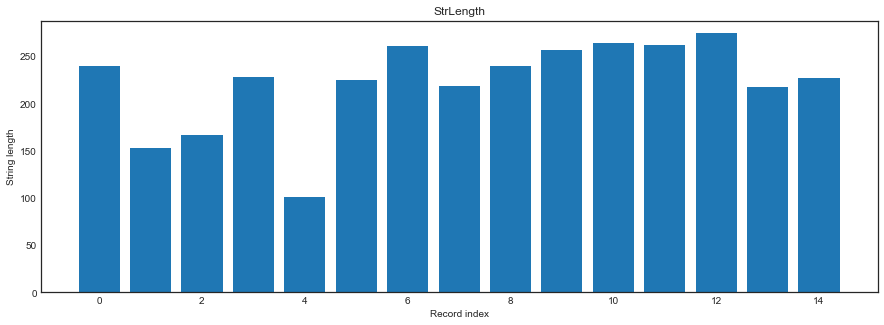

In [25]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

Results dataframe

In [26]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

### CORA: Best Jaccard execution

In [27]:
%%time

ngramms= 3                                  # If jaccard used, n-gramms are used
jaccard_withchars = True                    # n-gramms either of chars and either of words

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_dissimilarityDistance= 0.5                       # The threshold for the triangle inequality
distanceMetric= 'jaccard'                   # Distance metric between the strings when creating the space
prototypesFilterThr = 0.6                   # Prototypes must differ more than that threshold

# Embedding phase
distanceMetricEmbedding = 'euclid_jaccard'  # Embedding metric

# WTA algorithm
windowSize = 70                           # Vector size for WTA algo
number_of_permutations = 1                # WTA number of permutations

# Similarity evaluation
similarityVectors = 'ranked'                  # which vectors will be passed to WTA step
similarityThreshold = 0.6                    # Similarity threshold for the final step
metric = 'kendal'                             # Similarity metric between vectors

start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,
    max_dissimilarityDistance= max_dissimilarityDistance,
    windowSize= windowSize,
    similarityThreshold= similarityThreshold,
    metric=metric,
    similarityVectors=similarityVectors,
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr,
    verboseLevel = 0
)
model.hackForDebug(labels_groundTruth, true_matrix)
model = model.fit(data)
acc,f1,precision,recall = evaluate(model.mapping_matrix, true_matrix, True)
report(model)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Final number of prototypes:  3

# Finished in 0.0346 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created

# Finished in 0.0332 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:

- WTA number of buckets:  2

# Finished in 0.0021 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


C:\Users\nikol\Desktop\GitHub\Entity-Resolution-in-Dissimilarity-Spaces\src\hash\wta.py:34: UserWarning: Window size greater than vector dimension
  warnings.warn("Window size greater than vector dimension")




# Finished in 0.0720 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################



NameError: name 'evaluate' is not defined

In [28]:
model.Embeddings

array([[1, 3, 2],
       [3, 1, 2],
       [3, 1, 2],
       [3, 1, 2],
       [3, 1, 2],
       [3, 2, 1],
       [3, 2, 1],
       [3, 2, 1],
       [3, 2, 1],
       [3, 2, 1],
       [3, 2, 1],
       [3, 2, 1],
       [3, 2, 1],
       [3, 2, 1],
       [2, 3, 1]], dtype=int64)

In [29]:
# groups

In [30]:
results_dataframe

,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_with_chars,Accuracy,Precision,Recall,F1,Time


### CORA: Best Edit distance execution

In [34]:
%%time

# Prototype selection
max_numberOf_clusters= 1000                  # Νumber of loops for finding representatives, it is an upper bound of clusters.
max_dissimilarityDistance= 100                       # The threshold for the triangle inequality
distanceMetric= 'edit'                   # Distance metric between the vectors when creating the space
prototypesFilterThr = 100                # Prototypes must differ more that threshold

# Embedding phase
distanceMetricEmbedding = 'l_inf'  # Embedding metric

# WTA algorithm
windowSize= 37                             # Vector size for WTA algo
number_of_permutations = 3                 # WTA number of permutations


# Similarity evaluation
similarityVectors='initial'                  # which vectors will be passed to WTA step
similarityThreshold= 0.7                    # Similarity threshold for the final step
metric='kendal'                             # Similarity metric between vectors


start = time.time()
model = RankedWTAHash(
    max_numberOf_clusters= max_numberOf_clusters,    
    max_dissimilarityDistance= max_dissimilarityDistance,    
    windowSize= windowSize,    
    similarityThreshold= similarityThreshold,    
    metric= metric,    
    similarityVectors=similarityVectors,    
    number_of_permutations = number_of_permutations,
    distanceMetric= distanceMetric,
    distanceMetricEmbedding = distanceMetricEmbedding,
    ngramms= ngramms,
    jaccard_withchars = jaccard_withchars,
    prototypesFilterThr = prototypesFilterThr
)
model = model.fit(data)
acc,f1,precision,recall = evaluate(model.mapping_matrix,true_matrix, True)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_dissimilarityDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Final number of prototypes:  3

# Finished in 0.0307 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created

# Finished in 0.0365 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:

- WTA number of buckets:  3

# Finished in 0.0010 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


C:\Users\nikol\Desktop\GitHub\Entity-Resolution-in-Dissimilarity-Spaces\src\hash\wta.py:34: UserWarning: Window size greater than vector dimension
  warnings.warn("Window size greater than vector dimension")


AttributeError: 'RankedWTAHash' object has no attribute 'true_matrix'

### Embeddings

In [32]:
pcaComponents = PCA_SpaceVisualization_3D(model.Embeddings,model.prototypeArray)

ValueError: Unknown projection '3d'

<Figure size 864x720 with 0 Axes>

In [ ]:
pcaComponents = PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray, decompositionMenthod='MSD')

In [ ]:
pcaComponents = WTA_PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray,model.HashedClusters, decompositionMenthod='MSD')

In [ ]:
pcaComponents = WTA_PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray,model.HashedClusters,withgroundruth=True,groundruth=labels_groundTruth,title='MSD visualization GroundTruth', decompositionMenthod='MSD')

In [ ]:
pcaComponents = WTA_PCA_SpaceVisualization_3D(model.rankedVectors,model.prototypeArray,model.HashedClusters,withgroundruth=True,groundruth=labels_groundTruth,title='PCA visualization GroundTruth', decompositionMenthod='PCA')

### MMD${}^2$ error between distribution of Prototypes and whole Dataset

In [ ]:
myMMD2(model)

### Grid search each section

#### GridSearch function

In [ ]:
from utils.grid_search import GridSearch

#### __[i]__ __Prototype selection__


First of all, we need to find some ways on evaluating the prototype selection algorithm. Vantage Spaces are not something new, but we need to examine its behaviour on CORA dataset.

Goals:

- __Variance__: We want prototypes to be as much different as possible. 
- __Number__: We need a large amount of prototypes.

Ways to evaluate the algorithm:

- Mean distance between selected prototypes
- Show a HeatMap of consisted of the distances
- Some greedy search on the parameters. Parameters to fine tunne:
    -  ```max_numberOf_clusters```: Νumber of loops for finding representatives, it is an upper bound of clusters.
    -  ```max_dissimilarityDistance```:  The threshold for the triangle inequality
    -  ```distanceMetric```:  Distance metric between the vectors when creating the space
    -  ```prototypesFilterThr```: Prototypes must differ more that threshold


All these parameters will be tested both for edit distance and jaccard with 3-grams.

__Maximum mean discrepancy (MMD)__, which measures the discrepancy between two distributions. The selection of prototypes creates a density distribution of prototypes. We want to evaluate whether the prototypes distribution differs from the data distribution. We estimate both with kernel density functions. The maximum mean discrepancy measures the difference between two distributions, which is the supremum over a function space of differences between the expectations according to the two distributions. All clear? Personally, I understand these concepts much better when I see how something is calculated with data. The following formula shows how to calculate the squared MMD measure (MMD2):
    $$
    MMD^2=\frac{1}{m^2}\sum_{i,j=1}^m{}k(z_i,z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n}k(z_i,x_j)+\frac{1}{n^2}\sum_{i,j=1}^n{}k(x_i,x_j)
    $$
    
- __k__ is a kernel function that measures the similarity of two points
- __m__ is the number of prototypes 
- __n__ is the number of data points x in our original dataset. 
- The prototypes z are a selection of data points x. 

    
Each point is multidimensional, that is it can have multiple features. The goal of MMD-critic is to minimize MMD2. The closer MMD2 is to zero, the better the distribution of the prototypes fits the data. The key to bringing MMD2 down to zero is the term in the middle, which calculates the average proximity between the prototypes and all other data points (multiplied by 2). If this term adds up to the first term (the average proximity of the prototypes to each other) plus the last term (the average proximity of the data points to each other), then the prototypes explain the data perfectly.  

In [ ]:
max_numberOf_clusters= [5000]
max_dissimilarityDistance= [20]
prototypesFilterThr = [80]

distanceMetric= ['edit']

# ---------------- #

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']

results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_dissimilarityDistance= [0.7,0.8]
prototypesFilterThr = [0.2,0.3]

distanceMetric= ['jaccard']


ngramms= [2,3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

##### Remarks

Two main factors:

- __numOfPrototypes__ and
- __protSelectionVariance__

The first one is the number of prototypes selected, which is very important as more prototypes will enhance model when creating the embeddings.

The second one is the average distance between all the prototypes selected. As this factor increases, the prototypes selected differ the most.


According to the above, best parameters so far:

- __Edit distance__


- __Jaccard with 3-grams__



#### __[ii]__ Fine tunning  __Embedding phase__

Ways to evaluate the __Embedding phase__:

- Use a PCA after embeddings made and check selected prototypes 

In [ ]:
max_numberOf_clusters= [5000]
max_dissimilarityDistance= [20,50]
prototypesFilterThr = [80]

distanceMetric= ['edit']

# ---------------- #

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['euclidean','l_inf','edit']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']

results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_dissimilarityDistance= [0.7,0.8]
prototypesFilterThr = [0.2,0.3]

distanceMetric= ['jaccard']


ngramms= [2,3]  
jaccard_withchars = [True] 

# ---------------- #

distanceMetricEmbedding = ['euclidean']

windowSize= [50]
number_of_permutations = [5]

similarityThreshold= [0.7]
similarityVectors= ['ranked']
metric= ['kendal']


results_section1_jac = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=1
)

#### [iii] Fine tunning  __WTA algorithm__


Goals:

- __Ranked vectors dimension__
- __Permutations__: A number of permutations will be forced in order to better split data into buckets.

 
Parameters to fine tunne:

- ```windowSize```: Vector size after WTA
- ```number_of_permutations```: How many times vectors will be permuted and hashed

All these parameters will be tested both for edit distance and jaccard with 3-grams.

#### [iv] Fine tunning  __Similarity checking__

##### Various similarity metrics to check
These functions are for the similarity checking phase.

In [ ]:
from utils.metrics import spearman_footrule_distance, kendall_top_k, rbo

##### Spearman footrule distance

##### Ravi Kumar generalized Kendall Tau

##### Rank Biased Overlap (RBO) 
Article: https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899

##### Winner Takes All proposed 

#### [v] Model final fine tunning


There are four ways to check if the predictions are right or wrong:
- __TN__ / True Negative: the case was negative and predicted negative
- __TP__ / True Positive: the case was positive and predicted positive
- __FN__ / False Negative: the case was positive but predicted negative
- __FP__ / False Positive: the case was negative but predicted positive

__Precision — What percent of your predictions were correct?__


Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.
Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)


__Recall — What percent of the positive cases did you catch?__


Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

__F1 score — What percent of positive predictions were correct?__


The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

__Support__


Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

##### Edit distance

In [ ]:
max_numberOf_clusters= [100,500,1000]
max_dissimilarityDistance= [50,100]
prototypesFilterThr = [20,40,70]

distanceMetric= ['edit']

ngramms= [3]  
jaccard_withchars = [False] 

distanceMetricEmbedding = ['l_inf','euclidean']

windowSize= [16,32,64,128]
number_of_permutations = [1,4,8]

similarityThreshold= [0.7,0.75,0.8]
similarityVectors= ['initial','ranked']
metric= ['kendal','customKendal']



results_section1_edit = GridSearch_cora(
    data,true_matrix,
    max_numberOf_clusters,
    max_dissimilarityDistance,
    similarityThreshold,
    windowSize,
    metric,
    similarityVectors,
    distanceMetricEmbedding,
    distanceMetric,
    number_of_permutations,
    ngramms,
    jaccard_withchars,
    prototypesFilterThr,
    earlyStop=0
)

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)